### TEXT CLASSIFICATION AND SENTIMENT ANALYSIS

#### Improving Customer Satisfaction through Automated Review Sentiment Analysis
Overview

You are a product manager at an e-commerce company like Amazon. Your company receives thousands of customer reviews daily for various products. While ratings are available, they don’t always capture customer sentiment accurately — especially when the text and rating conflict.

Business Problem:

Your goal is to build an automated Sentiment Analysis System to classify incoming product reviews as Positive or Negative. This will help:

•	Monitor product performance in real-time

•	Identify products with sudden spikes in negative feedback

•	Improve customer satisfaction by addressing complaints faster


In [43]:
import os
import re
import sys
import joblib
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# NLP helpers
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#### Dataset
•	Each row is one Amazon customer review for some product.

•	The dataset has been pre-labeled — so you already know if the review is positive or negative.

•	This is a typical sentiment analysis dataset, often used for training or testing natural language processing (NLP) models.

📊 Rows:
10,000 customer reviews

📑 Columns:

1.	label
  
o	Type: Text (Categorical)
o	Values: pos (positive) or neg (negative)
o	What it means: The sentiment of the review — whether the customer’s feedback is positive or negative.

2.	review

o	Type: Text
o	Values: Actual text of the review written by the customer.
o	What it means: What the customer said about the product in their own words — for example: “Excellent Soundtrack! I love it!”


In [67]:
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [68]:
df =pd.read_csv('amazonreviews.tsv',sep='\t')
df.shape

(10000, 2)

#### Tasks
Data Cleaning: Remove duplicates, handle missing reviews if any, preprocess text (lowercasing, stopwords removal).


In [69]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [70]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)                     
    text = re.sub(r'http\S+|www\.\S+', ' ', text)            
    text = re.sub(r'[^a-z0-9\s\']', ' ', text)               
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [71]:
df['clean_review'] = df['review'].apply(clean_text)
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

In [72]:
df[['label','word_count']].describe()

,word_count
count,10000.000000
mean,80.562300
std,43.687044
min,4.000000
25%,44.000000
50%,72.000000
75%,111.000000
max,215.000000


In [73]:
df['label'].value_counts()

label
neg    5097
pos    4903
Name: count, dtype: int64

In [74]:
stop_words = set(stopwords.words('english'))

In [75]:
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

In [76]:
df['tokens'] = df['clean_review'].apply(tokenize)

#### Exploratory Analysis: Word clouds, sentiment distribution, most common positive/negative words.

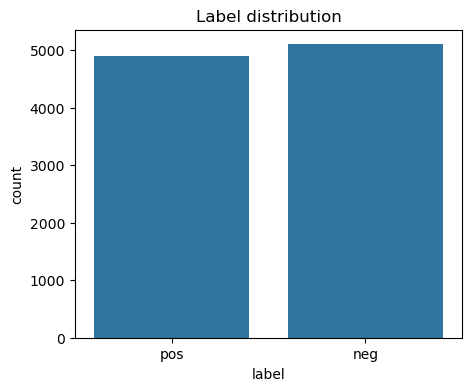

In [77]:
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df)
plt.title('Label distribution')
plt.show()

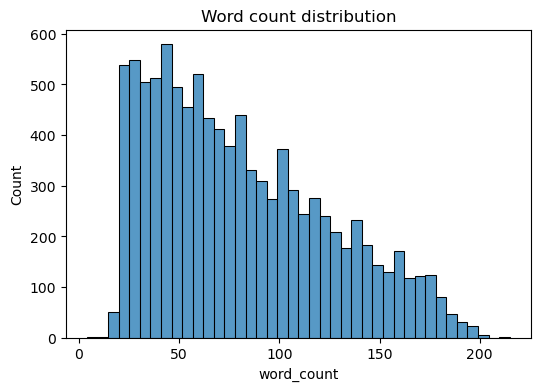

In [78]:
plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=40)
plt.title('Word count distribution')
plt.show()

In [79]:
def top_n_words(tokens_series, n=25):
    all_tokens = [t for tokens in tokens_series for t in tokens]
    return Counter(all_tokens).most_common(n)

In [80]:
top_pos = top_n_words(df[df['label']=='pos']['tokens'])
top_neg = top_n_words(df[df['label']=='neg']['tokens'])

In [81]:
top_pos[:20]

[('book', 3390),
 ('great', 2135),
 ('one', 1916),
 ('good', 1667),
 ('read', 1605),
 ('like', 1290),
 ('movie', 1117),
 ('would', 1007),
 ('well', 944),
 ('time', 923),
 ('love', 911),
 ('really', 832),
 ('best', 813),
 ('get', 805),
 ('story', 730),
 ('first', 724),
 ('much', 664),
 ('cd', 618),
 ('music', 575),
 ('also', 575)]

In [82]:
top_neg[:20]

[('book', 3277),
 ('one', 2099),
 ('would', 1608),
 ('like', 1568),
 ('movie', 1519),
 ('read', 1222),
 ('good', 1160),
 ('get', 1151),
 ('time', 1072),
 ('even', 909),
 ('could', 884),
 ('buy', 834),
 ('really', 783),
 ('much', 782),
 ('money', 767),
 ('bad', 764),
 ('first', 760),
 ('better', 677),
 ('great', 643),
 ('story', 640)]

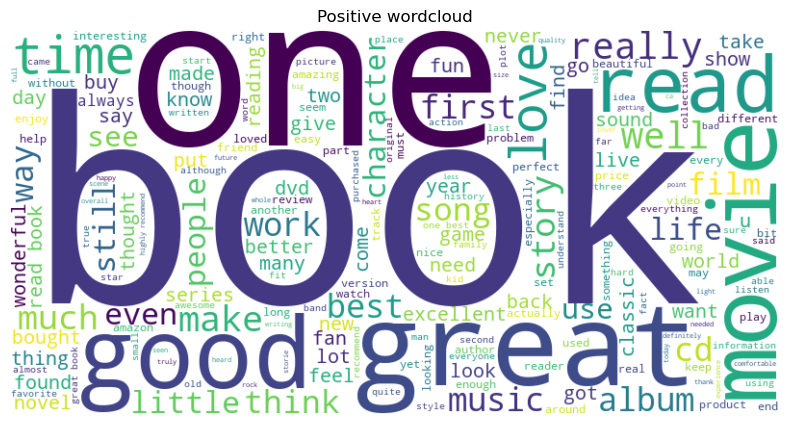

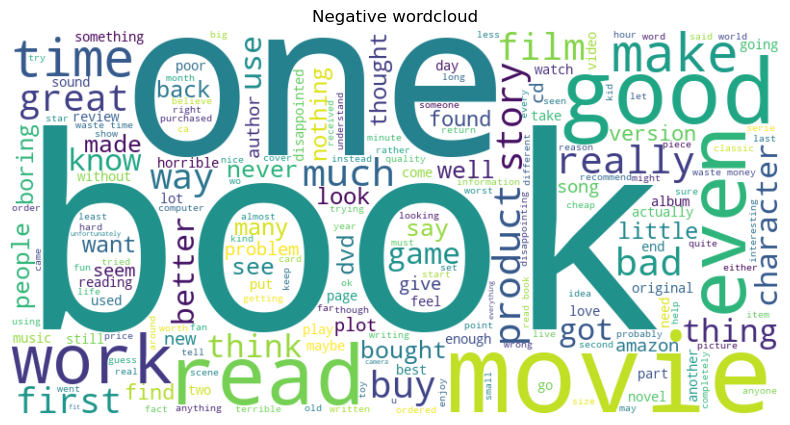

In [83]:
try:
    from wordcloud import WordCloud
    pos_text = " ".join([" ".join(toks) for toks in df[df['label']=='pos']['tokens']])
    neg_text = " ".join([" ".join(toks) for toks in df[df['label']=='neg']['tokens']])

    wc_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
    wc_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

    plt.figure(figsize=(12,5))
    plt.imshow(wc_pos, interpolation='bilinear'); plt.axis('off'); plt.title('Positive wordcloud'); plt.show()
    plt.figure(figsize=(12,5))
    plt.imshow(wc_neg, interpolation='bilinear'); plt.axis('off'); plt.title('Negative wordcloud'); plt.show()
except Exception as e:
    print("wordcloud not available or failed:", e)
    top_pos_df = pd.DataFrame(top_pos, columns=['word','count']).head(20)
    top_neg_df = pd.DataFrame(top_neg, columns=['word','count']).head(20)
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    sns.barplot(y='word', x='count', data=top_pos_df, ax=axes[0]); axes[0].set_title('Top words (pos)')
    sns.barplot(y='word', x='count', data=top_neg_df, ax=axes[1]); axes[1].set_title('Top words (neg)')
    plt.tight_layout()
    plt.show()


In [85]:
X = df['clean_review'].values
y = df['label'].values
le = LabelEncoder()
y_enc = le.fit_transform(y)
dict(zip(le.classes_, le.transform(le.classes_)))

{'neg': np.int64(0), 'pos': np.int64(1)}

#### Model Development: Use NLP techniques (TF-IDF, Word2Vec, or BERT embeddings) with models like Logistic Regression, SVM, or Neural Networks.

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000,), (2000,), (8000,), (2000,))

In [89]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3, stop_words='english')
clf_lr = LogisticRegression(max_iter=1000, random_state=42)

In [90]:

pipeline_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf_lr)
])

In [91]:
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

#### Validation: Use train/test split, cross-validation, and metrics like accuracy, F1-score.

In [92]:
accuracy_score(y_test, y_pred)

0.857

In [93]:
f1_score(y_test, y_pred)

0.852880658436214

In [94]:
classification_report(y_test, y_pred, target_names=le.classes_)

'              precision    recall  f1-score   support\n\n         neg       0.85      0.87      0.86      1019\n         pos       0.86      0.85      0.85       981\n\n    accuracy                           0.86      2000\n   macro avg       0.86      0.86      0.86      2000\nweighted avg       0.86      0.86      0.86      2000\n'

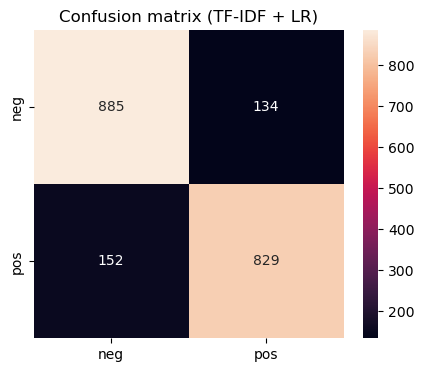

In [95]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix (TF-IDF + LR)")
plt.show()

In [97]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
cv_scores

array([0.84308842, 0.85130823, 0.85914595, 0.85714286, 0.87420584])

In [98]:
cv_scores.mean()

np.float64(0.856978261136377)

In [100]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3, stop_words='english')),
    ('svc', LinearSVC(max_iter=5000, random_state=42))
])

In [101]:
pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_test)

In [102]:
accuracy_score(y_test, y_pred_svc)

0.8525

In [103]:
f1_score(y_test, y_pred_svc)

0.8494129657988769

In [105]:
tfidf_small = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=3, stop_words='english')
X_train_tfidf = tfidf_small.fit_transform(X_train)
X_test_tfidf = tfidf_small.transform(X_test)

In [106]:
mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=30, random_state=42)

In [112]:
import warnings
warnings.filterwarnings('ignore')
mlp.fit(X_train_tfidf, y_train)
y_pred_mlp = mlp.predict(X_test_tfidf)

In [113]:
accuracy_score(y_test, y_pred_mlp)

0.8355

In [114]:
f1_score(y_test, y_pred_mlp)

0.8323993886907795

In [115]:
try:
    from gensim.models import Word2Vec
    print("Training Word2Vec (this may take a while)...")
    sentences = df['tokens'].tolist()
    w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4, seed=42)

    def avg_w2v(tokens, model, vector_size=100):
        vec = np.zeros(vector_size, dtype=float)
        count = 0
        for t in tokens:
            if t in model.wv:
                vec += model.wv[t]
                count += 1
        return vec / count if count > 0 else vec

    X_w2v = np.vstack(df['tokens'].apply(lambda t: avg_w2v(t, w2v_model, vector_size=100)).values)
    y_all = le.transform(df['label'])
    X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X_w2v, y_all, test_size=0.2, stratify=y_all, random_state=42)

    lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
    lr_w2v.fit(X_w2v_train, y_w2v_train)
    y_pred_w2v = lr_w2v.predict(X_w2v_test)
    print("W2V-Avg + LR - F1:", f1_score(y_w2v_test, y_pred_w2v))
except Exception as e:
    print("gensim/Word2Vec not available or failed:", e)
    print("Skipping Word2Vec step (not required for baseline).")

Training Word2Vec (this may take a while)...
W2V-Avg + LR - F1: 0.7303252885624344


In [116]:
 try:
    vec = pipeline_lr.named_steps['tfidf']
    clf = pipeline_lr.named_steps['clf']
    if hasattr(clf, 'coef_'):
        feature_names = vec.get_feature_names_out()
        coefs = clf.coef_[0]
        top_pos_idx = np.argsort(coefs)[-20:][::-1]
        top_neg_idx = np.argsort(coefs)[:20]
        print("Top positive features:")
        for idx in top_pos_idx[:20]:
            print(f"{feature_names[idx]} ({coefs[idx]:.4f})")
        print("\nTop negative features:")
        for idx in top_neg_idx[:20]:
            print(f"{feature_names[idx]} ({coefs[idx]:.4f})")
except Exception as e:
    print("Could not extract feature importances:", e)

Top positive features:
great (7.6422)
excellent (4.8124)
love (4.6126)
best (4.5267)
good (3.6730)
perfect (3.6598)
wonderful (3.0813)
amazing (3.0443)
easy (2.9678)
favorite (2.6766)
loved (2.5191)
works (2.4599)
loves (2.4299)
awesome (2.3741)
fun (2.3093)
highly (2.2499)
beautiful (2.1628)
fantastic (2.0324)
enjoyed (1.9500)
life (1.9254)

Top negative features:
boring (-5.0618)
bad (-4.7314)
worst (-4.2409)
disappointed (-4.1566)
waste (-4.1184)
poor (-4.0675)
money (-3.5821)
don (-3.1904)
disappointing (-3.1374)
horrible (-2.9537)
terrible (-2.8063)
did (-2.3897)
disappointment (-2.2492)
didn (-2.2344)
return (-2.1876)
maybe (-2.1136)
idea (-2.0964)
doesn (-2.0704)
received (-2.0344)
waste money (-1.9945)


### Evaluation Criteria
•	Correct implementation of data preprocessing and feature extraction.

•	Accuracy and robustness of the classification model.

•	Depth and insightfulness of the sentiment analysis.

•	Clarity and thoroughness of the evaluation and discussion sections.

•	Overall quality and organization of the report and code.

Good luck, and we look forward to your insightful analysis of the given dataset!



In [117]:
def evaluate_pipeline(pipeline, X_test, y_test, label_encoder):
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.show()

Accuracy: 0.857
Precision: 0.8608515057113187
Recall: 0.8450560652395515
F1: 0.852880658436214

Classification report:
               precision    recall  f1-score   support

         neg       0.85      0.87      0.86      1019
         pos       0.86      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



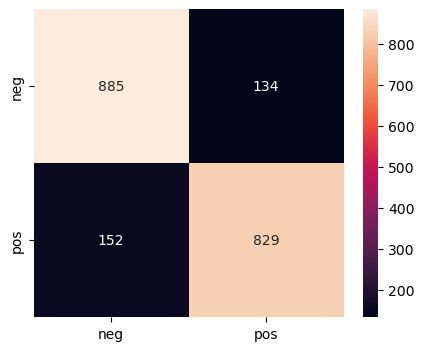

In [118]:
evaluate_pipeline(pipeline_lr, X_test, y_test, le)